## 1. 读取IC50数据

In [1]:
import pandas as pd
df = pd.read_csv('AChE.IC50.csv',sep=';')  #ChEMBL上下载的csv是以分号为分隔符的
names = ['Molecule ChEMBL ID', 'Molecule Name', 'Smiles', 
         'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units',
         'Data Validity Comment', 'Comment',] # 仅关注这几列数据
df = df[names]
df = df[df['Smiles'].notnull()]
df = df.sort_values('Standard Value').drop_duplicates(['Molecule ChEMBL ID'])  # 有的分子有多个IC50数据，仅保留一个
df.shape

(5343, 9)

## 2.计算分子描述符

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole # 在jupyter-notebook中显示分子结构
from mordred import Calculator, descriptors
from molvs import Standardizer
import cPickle as pickle
import os

In [3]:
def calc_descriptors(SMI_df):
    # create descriptor calculator with all descriptors
    calc = Calculator(descriptors, ignore_3D=True)
    s = Standardizer()
    mols = [Chem.MolFromSmiles(smi) for smi in SMI_df]
    mols = [s.largest_fragment(m) for m in mols]
    df = calc.pandas(mols)
    return df
# --- I/O function
def save(data,f):
    with open(f,"w") as f1:
        pickle.dump(data,f1)    
def load(f):
    with open(f,"r") as f1:
        d = pickle.load(f1)
    return d

In [4]:
if os.path.isfile('descriptors-ic50.data') :
    descriptors_ic50 = load('descriptors-ic50.data')
else:
    descriptors_ic50 = calc_descriptors(df['Smiles'])
    save(descriptors_ic50,'descriptors-ic50.data')

## 3. 预测活性

In [5]:
clf,scaler,features = load('model')

X = descriptors_ic50[features].values
X = scaler.fit_transform(X)   # 用训练集中的scaler参数标准化数据集
y_prediction = clf.predict(X)

In [6]:
df['label'] = y_prediction
active = df[ df['label'] == 1 ]
true_active = active[ active['Standard Value']<1e4 ]
df_true_active = df[df['Standard Value']<1e4]

print ("N predicted: %d; N True Positive:%d; Accuracy:%f" % (active.shape[0],true_active.shape[0],true_active.shape[0]*1.0/active.shape[0]))
print ("N True Positive in Database: %d" % df_true_active.shape[0])

N predicted: 1377; N True Positive:1129; Accuracy:0.819898
N True Positive in Database: 2949


## 4. 可视化数据分布

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

0.551937113981


/home/liu/storage/soft/miniconda/2018.12/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


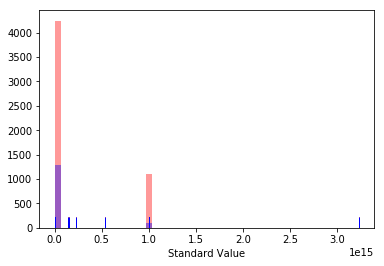

In [8]:
# 数据集中IC50<1e4的分子数占55%，SVM预测的活性分子中IC50<1e4的分子数占82% 
print df[df['Standard Value'] < 1e4].shape[0]*1.0/df.shape[0]

# SVM漏筛了相当多的活性分子，但是筛出来的分子中高活性分子的比例大
sns.distplot(df['Standard Value'].fillna(1e15),kde=False,rug=True,color='r') # database IC50 counts
sns.distplot(active['Standard Value'].fillna(1e15),kde=False,rug=True,color='b') # active IC50 counts

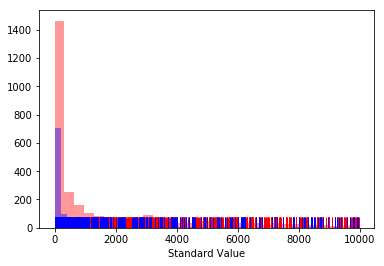

In [9]:
sns.distplot(df[df['Standard Value']<1e4]['Standard Value'],kde=False,rug=True,color='r') #
sns.distplot(active[active['Standard Value']<1e4]['Standard Value'],kde=False,rug=True,color='b') # 